In [2]:
from snowflake.snowpark.session import Session
from sklearn.experimental import enable_iterative_imputer
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
# snowpark session
account = 'yzb80796.us-east-1'
user = 'DBOUQUIN@NPCA.ORG'
role = 'ACCOUNTADMIN'
database = 'DEATH_DB'
schema = 'PUBLIC'
warehouse = 'DATASCIENCE_WH'

In [3]:
# Establish the connection
connection_parameters = {
    "user": user,
    "account": account,
    "role": role,
    "warehouse": warehouse,
    "database": database,
    "schema": schema,
    "authenticator": "externalbrowser"
}

session = Session.builder.configs(connection_parameters).create()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://login.microsoftonline.com/79b6ced6-848a-442a-bbf4-34232dae8bbe/saml2?SAMLRequest=lZJdb9owFIb%2FSuRdJ3FCFsACKgpDY%2F2A8VFVvXOSE7Dq2MzHaUp%2F%2FUwoUnfRSruLnOe1H%2Fs9g6vXSnovYFBoNSRRQIkHKteFULsh2W5mfo94aLkquNQKhuQISK5GA%2BSVPLBxbfdqBX9qQOu5jRSy9seQ1EYxzVEgU7wCZDZn6%2FHdLYsDyg5GW51rST5Evk5wRDDWGV4iBQqnt7f2wMKwaZqg6QTa7MKYUhrSfuioE%2FLtwr%2B6O33CRyFNTrwjHL58d7sW6vwEX2llZwjZz81m6S8X6w3xxhfViVZYV2DWYF5EDtvV7VkAncHxLevRbj8NavSBo%2FWjAJVuSsmfIdfVobZu28B9hSUUodQ74W4%2Bnw7J4VkUi8e8W%2FKnrYzzx7cxNd1f89XqOLmf7bKHesH313fxze9ldVMff%2BTEe7hUG5%2BqnSPWMFenQq1bonHi09SPOhsasU7KvneDNE6eiDd1hQrFbZu8WLceQSVyo1GXVispFLSW3X6W5lCkfi%2FpcT9JYu5nWZn4nSTuxAWHXpZBeKo5JufRYa2IGf33gwzCj%2FH3Mbx3zcynSy1FfvRm2lTcfl5cFETtiij8skUZVFzIcVEYQHQFSqmbiQFu3bRbUwMJR%2BdT%2F5

In [4]:
query = "SELECT * FROM bequests"

In [5]:
bequests_df = session.sql(query).to_pandas()
bequests_df.head()

,ROI_ID,ROI_FAMILY_ID,HOH_BIRTH_DATE,CITY,STATE,ZIPCODE,REGION_CODE,TOTAL_TRANSACTIONS,TOTAL_AMOUNT,FIRST_GIFT_AMOUNT,...,IWAVE_PLANNED_GIVING,IWAVE_PROSPECT_CLASSIFICATION,IWAVE_SUGGESTED_CULTIVATION,IWAVE_SUGGESTED_ENGAGEMENT_LEAD,FIRST_BEQUEST_DATE,LAST_BEQUEST_DATE,FIRST_BEQUEST_FISCAL_YEAR,LAST_BEQUEST_FISCAL_YEAR,FIRST_BEQUEST_NET_AMOUNT,LAST_BEQUEST_NET_AMOUNT
0,33930223,33930223,1942-11-01,New York,NY,10028,NERO,3.0,55.0,25.0,...,,,,,None,None,NaN,NaN,NaN,NaN
1,33930231,33930231,1946-08-07,Hampton,CT,06247-1312,NERO,29.0,950.0,15.0,...,,NPCA Champion,Annual,Membership,None,None,NaN,NaN,NaN,NaN
2,33930249,33930249,1964-02-11,Danbury,CT,06810-7910,NERO,14.0,415.0,15.0,...,Potential PG Prospect,NPCA Champion,Annual,Membership,None,None,NaN,NaN,NaN,NaN
3,33930264,33930264,None,Calistoga,CA,94515-1569,PARO,1.0,15.0,15.0,...,,,,,None,None,NaN,NaN,NaN,NaN
4,33930272,33930272,1964-12-20,Princeton,NJ,08540-9491,NERO,23.0,1720.0,25.0,...,Potential PG Prospect,NPCA Champion,Research Driven,Membership,None,None,NaN,NaN,NaN,NaN


In [6]:
bequests_df.columns

Index(['ROI_ID', 'ROI_FAMILY_ID', 'HOH_BIRTH_DATE', 'CITY', 'STATE', 'ZIPCODE',
       'REGION_CODE', 'TOTAL_TRANSACTIONS', 'TOTAL_AMOUNT',
       'FIRST_GIFT_AMOUNT', 'FIRST_GIFT_DATE', 'MRC_DATE', 'MRC_AMOUNT',
       'HPC_DATE', 'HPC_AMOUNT', 'IWAVE_EXTERNAL_GIVING_VELOCITY',
       'IWAVE_GIVING_CAPACITY_5YR', 'IWAVE_GIVING_CAPACITY_SOURCE',
       'IWAVE_PLANNED_GIVING', 'IWAVE_PROSPECT_CLASSIFICATION',
       'IWAVE_SUGGESTED_CULTIVATION', 'IWAVE_SUGGESTED_ENGAGEMENT_LEAD',
       'FIRST_BEQUEST_DATE', 'LAST_BEQUEST_DATE', 'FIRST_BEQUEST_FISCAL_YEAR',
       'LAST_BEQUEST_FISCAL_YEAR', 'FIRST_BEQUEST_NET_AMOUNT',
       'LAST_BEQUEST_NET_AMOUNT'],
      dtype='object')

In [7]:
# Drop records where TOTAL_TRANSACTIONS is null (keep only those who have donated at least once)
bequests_df = bequests_df.dropna(subset=['TOTAL_TRANSACTIONS'])

In [8]:
# import life expectancy data
le_df = pd.read_csv('U.S._State_Life_Expectancy_by_Sex__2020.csv')

In [9]:
# keep only rows in le_df where Sex is "Total"
le_df = le_df[le_df['Sex'] == 'Total']

In [10]:
# drop Sex column
le_df = le_df.drop(columns= 'Sex')

In [11]:
# Dictionary of state abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL',
    'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN',
    'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME',
    'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE',
    'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM',
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI',
    'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX',
    'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}

# Applying the dictionary to replace full state names with abbreviations
le_df['State'] = le_df['State'].map(state_abbreviations)
le_df.head()


,State,LE,SE,Quartile
0,AL,73.2,0.067,71.9 - 75.3
1,AK,76.6,0.176,75.4 - 76.8
2,AZ,76.3,0.055,75.4 - 76.8
3,AR,73.8,0.086,71.9 - 75.3
4,CA,79.0,0.022,78.1 - 80.7


In [12]:
# Load the deaths data
deaths_df = pd.read_csv('death_flags.csv')
# Trim white space from column names and replace spaces with underscores
deaths_df.columns = deaths_df.columns.str.strip().str.replace(' ', '_')
deaths_df.columns

Index(['ROI_ID', 'ROI_FAMILY_ID', 'ROI_ORIGINAL_ID', 'ROI_STATUS',
       'LAST_CHANGE_USER', 'LAST_CHANGE_DATE', 'FLAG_ID', 'ORIGINATION_VENDOR',
       'EFFECTIVE_DATE', 'END_DATE', 'REMOVAL_DATE', 'FLAGSTD_CODE',
       'FLAGSTD_NAME', 'ORIGINATION_VENDOR_CODE', 'ORIGINATION_VENDOR_NAME'],
      dtype='object')

In [13]:
deaths_df.head()

,ROI_ID,ROI_FAMILY_ID,ROI_ORIGINAL_ID,ROI_STATUS,LAST_CHANGE_USER,LAST_CHANGE_DATE,FLAG_ID,ORIGINATION_VENDOR,EFFECTIVE_DATE,END_DATE,REMOVAL_DATE,FLAGSTD_CODE,FLAGSTD_NAME,ORIGINATION_VENDOR_CODE,ORIGINATION_VENDOR_NAME
0,26,26,26.0,A,TVINES,05/15/2019 15:43:22,592,669,03/12/2010,NaN,NaN,DECEASED,Deceased,ROI SOLUTIONS,ROI Solutions
1,75,75,75.0,A,KHEISTON UP_10691_556864,05/11/2020 17:00:06,592,207285,03/18/2020,NaN,NaN,DECEASED,Deceased,MERKLE,Merkle
2,216,216,216.0,A,ADAROSA_J083633,06/06/2024 13:57:19,592,669,05/15/2019,NaN,NaN,DECEASED,Deceased,ROI SOLUTIONS,ROI Solutions
3,1164,1164,1164.0,A,KJONES UP_10682_1001858 Merkle Upload for NPCA,10/30/2023 18:33:35,592,207285,09/27/2023,NaN,NaN,DECEASED,Deceased,MERKLE,Merkle
4,2782,2782,2782.0,A,ADAROSA_J083633,06/06/2024 13:57:52,592,669,05/15/2019,NaN,NaN,DECEASED,Deceased,ROI SOLUTIONS,ROI Solutions


In [14]:
# Add column called 'DEATH_FLAG' to bequests_df that is 1 if the ROI_FAMILY_ID is in deaths_df and 0 otherwise match on ROI_FAMILY_ID
bequests_df['DEATH_FLAG'] = bequests_df['ROI_FAMILY_ID'].isin(deaths_df['ROI_FAMILY_ID']).astype(int)
bequests_df['DEATH_FLAG'].dtype

dtype('int64')

In [15]:
# Find proportion of DEAD_FLAG that are 1
deads = bequests_df['DEATH_FLAG'].mean()
deads * 100

2.090474347938689

In [16]:
# Create YEARS_SINCE_FIRST_GIFT based on time since FIRST_GIFT_DATE
bequests_df['YEARS_SINCE_FIRST_GIFT'] = (datetime.now() - pd.to_datetime(bequests_df['FIRST_GIFT_DATE'])).dt.days // 365
# Drop FIRST_GIFT_DATE
bequests_df = bequests_df.drop(columns='FIRST_GIFT_DATE')

In [17]:
# Create YEARS_SINCE_MRC_GIFT based on time since MRC_DATE
bequests_df['YEARS_SINCE_MRC_GIFT'] = (datetime.now() - pd.to_datetime(bequests_df['MRC_DATE'])).dt.days // 365
# Drop MRC_DATE
bequests_df = bequests_df.drop(columns='MRC_DATE')

In [18]:
# Create YEARS_SINCE_HPC_GIFT based on time since HPC_DATE
bequests_df['YEARS_SINCE_HPC_GIFT'] = (datetime.now() - pd.to_datetime(bequests_df['HPC_DATE'])).dt.days // 365
# Drop HPC_DATE
bequests_df = bequests_df.drop(columns='HPC_DATE')

In [19]:
# Create a column BEQUEST_RECEIVED that is 1 if FIRST_BEQUEST_DATE is not NaT and 0 otherwise
bequests_df['BEQUEST_RECEIVED'] = bequests_df['FIRST_BEQUEST_DATE'].notnull().astype(int)

# Drop 'FIRST_BEQUEST_DATE'
bequests_df = bequests_df.drop(columns=['FIRST_BEQUEST_DATE'])

bequest_donors = bequests_df[bequests_df['BEQUEST_RECEIVED'] == 1]

In [20]:
# Create BIRTH_YEAR column from HOH_BIRTH_DATE
bequests_df['BIRTH_YEAR'] = pd.to_datetime(bequests_df['HOH_BIRTH_DATE']).dt.year
# Drop HOH_BIRTH_DATE
bequests_df = bequests_df.drop(columns='HOH_BIRTH_DATE')

In [21]:
# Function to match donors to life expectancy based location
def match_life_expectancy(row):
    location = row['STATE']  # Assuming 'region' column in your donor data
    le_data = le_df[(le_df['State'] == location)]
    return le_data['LE'].values[0] if not le_data.empty else np.nan

In [22]:
bequests_df['LE'] = bequests_df.apply(match_life_expectancy, axis=1)

In [23]:
# Drop all columns that start with IWAVE
iwave_cols = [col for col in bequests_df.columns if 'IWAVE' in col]
bequests_df = bequests_df.drop(columns=iwave_cols)

# Drop other cols
bequests_df = bequests_df.drop(columns=['CITY', 'ZIPCODE','LAST_BEQUEST_DATE',
                                         'FIRST_BEQUEST_FISCAL_YEAR', 'LAST_BEQUEST_FISCAL_YEAR',
                                         'FIRST_BEQUEST_NET_AMOUNT', 'LAST_BEQUEST_NET_AMOUNT'
                                         ])

# Drop 
bequests_df.columns

Index(['ROI_ID', 'ROI_FAMILY_ID', 'STATE', 'REGION_CODE', 'TOTAL_TRANSACTIONS',
       'TOTAL_AMOUNT', 'FIRST_GIFT_AMOUNT', 'MRC_AMOUNT', 'HPC_AMOUNT',
       'DEATH_FLAG', 'YEARS_SINCE_FIRST_GIFT', 'YEARS_SINCE_MRC_GIFT',
       'YEARS_SINCE_HPC_GIFT', 'BEQUEST_RECEIVED', 'BIRTH_YEAR', 'LE'],
      dtype='object')

In [24]:
# Drop records where LE is null
bequests_df = bequests_df.dropna(subset=['LE'])

In [25]:
# Find percentage of missing values in each column
missing = bequests_df.isnull().mean() * 100
missing

ROI_ID                     0.000000
ROI_FAMILY_ID              0.000000
STATE                      0.000000
REGION_CODE                0.000000
TOTAL_TRANSACTIONS         0.000000
TOTAL_AMOUNT               0.000000
FIRST_GIFT_AMOUNT          0.000000
MRC_AMOUNT                 0.000000
HPC_AMOUNT                 0.000000
DEATH_FLAG                 0.000000
YEARS_SINCE_FIRST_GIFT     0.000000
YEARS_SINCE_MRC_GIFT       0.000000
YEARS_SINCE_HPC_GIFT       0.000000
BEQUEST_RECEIVED           0.000000
BIRTH_YEAR                55.992312
LE                         0.000000
dtype: float64

In [26]:
# Write to csv
bequests_df.to_csv('bequests_cleaned.csv', index=False)

In [3]:
bequests_df = pd.read_csv('bequests_cleaned.csv')

## Impute missing values

In [4]:
bequests_df.shape

(4520008, 16)

In [5]:
bequests_df.dtypes

ROI_ID                      int64
ROI_FAMILY_ID               int64
STATE                      object
REGION_CODE                object
TOTAL_TRANSACTIONS        float64
TOTAL_AMOUNT              float64
FIRST_GIFT_AMOUNT         float64
MRC_AMOUNT                float64
HPC_AMOUNT                float64
DEATH_FLAG                  int64
YEARS_SINCE_FIRST_GIFT      int64
YEARS_SINCE_MRC_GIFT        int64
YEARS_SINCE_HPC_GIFT        int64
BEQUEST_RECEIVED            int64
BIRTH_YEAR                float64
LE                        float64
dtype: object

In [6]:
# find number of bequests received among dead people
bequests_df[bequests_df['DEATH_FLAG'] == 1]['BEQUEST_RECEIVED'].sum()

370

In [7]:
# find the number of bequests received among living people
bequests_df[bequests_df['DEATH_FLAG'] == 0]['BEQUEST_RECEIVED'].sum()

34

In [9]:
# List the ROI_ID of the bequests received among living people
bequests_df[bequests_df['DEATH_FLAG'] == 0][bequests_df['BEQUEST_RECEIVED'] == 1]['ROI_ID'].unique()

/var/folders/sz/t5qbt_3j01lc9b5ld0tfvkv80000gn/T/ipykernel_59023/3928934427.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bequests_df[bequests_df['DEATH_FLAG'] == 0][bequests_df['BEQUEST_RECEIVED'] == 1]['ROI_ID'].unique()


array([ 37725009,  38737730,  61620175,  64164387,  66606930,  81889172,
        83549576,  90275892,  91734608,  94412632,  94543436,  10860575,
        20423489,  26983619,  27396316, 100003858, 100004534, 100005730,
       100013705, 100135675, 100314125, 100329938, 100371765, 100460846,
       100548814, 100589613, 100600842, 100822093,  69629970,   2227494,
         5573985,   6675219,  16681983])

In [90]:
# total number of dead people
bequests_df['DEATH_FLAG'].sum()

94427

In [89]:
# proportion of bequestors among dead people
bequests_df[bequests_df['DEATH_FLAG'] == 1]['BEQUEST_RECEIVED'].sum() / bequests_df['DEATH_FLAG'].sum()

0.0039183708049604455

In [77]:
# Define imputers
imputers = {
    'median': SimpleImputer(strategy='median'),
    'mean': SimpleImputer(strategy='mean'),
    'mice': IterativeImputer(random_state=42)
}

In [78]:
# Store results
results = []

In [79]:
# Features to be used for prediction
features = [
    'REGION_CODE',
    'TOTAL_TRANSACTIONS',
    'TOTAL_AMOUNT',
    'FIRST_GIFT_AMOUNT',
    'MRC_AMOUNT',
    'HPC_AMOUNT',
    'YEARS_SINCE_FIRST_GIFT',
    'YEARS_SINCE_MRC_GIFT',
    'YEARS_SINCE_HPC_GIFT',
    'BIRTH_YEAR'
]

In [80]:
# Function to evaluate imputation method
def evaluate_imputation(bequests_df, imputer_name, imputer):
    # Impute BIRTH_YEAR
    bequests_df['BIRTH_YEAR'] = imputer.fit_transform(bequests_df[['BIRTH_YEAR']])
    
    # Encode categorical variables
    bequests_df = pd.get_dummies(bequests_df, columns=['REGION_CODE'], drop_first=True)
    
    # Define features after one-hot encoding
    feature_columns = [
        'TOTAL_TRANSACTIONS',
        'TOTAL_AMOUNT',
        'FIRST_GIFT_AMOUNT',
        'MRC_AMOUNT',
        'HPC_AMOUNT',
        'YEARS_SINCE_FIRST_GIFT',
        'YEARS_SINCE_MRC_GIFT',
        'YEARS_SINCE_HPC_GIFT',
        'BIRTH_YEAR'
    ] + [col for col in bequests_df.columns if col.startswith('REGION_CODE_')]
    
    # Filter the dataset to include only dead individuals in the test set
    test_df = bequests_df[bequests_df['DEATH_FLAG'] == 1]
    train_df = bequests_df[bequests_df['DEATH_FLAG'] == 0]

    # Predict Bequest Likelihood
    X_train = train_df[feature_columns]
    y_train = train_df['BEQUEST_RECEIVED']
    X_test = test_df[feature_columns]
    y_test = test_df['BEQUEST_RECEIVED']

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Train a classifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_res, y_train_res)

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Store results
    results.append({
        'imputer': imputer_name,
        'accuracy': accuracy,
        'report': pd.DataFrame(report).transpose(),
        'feature_importance': feature_importance
    })


In [ ]:
# Evaluate each imputation method
for imputer_name, imputer in imputers.items():
    evaluate_imputation(bequests_df.copy(), imputer_name, imputer)


In [ ]:
# Display results
for result in results:
    print(f"Imputer: {result['imputer']}")
    print(f"Accuracy: {result['accuracy']}")
    print(f"Classification Report: {result['report']}")
    print(f"Feature Importance:\n{result['feature_importance']}\n")


In [59]:
# Create dataframes for results
accuracy_df = pd.DataFrame({result['imputer']: [result['accuracy']] for result in results})
classification_reports = {result['imputer']: result['report'] for result in results}
feature_importances = {result['imputer']: result['feature_importance'] for result in results}

In [60]:
accuracy_df

,median,mean,mice
0,0.999942,0.999944,0.999944


In [61]:
classification_reports

{'median': {'0': {'precision': 0.9999502187058191,
   'recall': 0.9999922559175852,
   'f1-score': 0.9999712368699076,
   'support': 903916},
  '1': {'precision': 0.8541666666666666,
   'recall': 0.47674418604651164,
   'f1-score': 0.6119402985074627,
   'support': 86},
  'accuracy': 0.9999424780033672,
  'macro avg': {'precision': 0.9270584426862429,
   'recall': 0.7383682209820485,
   'f1-score': 0.8059557676886852,
   'support': 904002},
  'weighted avg': {'precision': 0.9999363499472597,
   'recall': 0.9999424780033672,
   'f1-score': 0.9999343225039005,
   'support': 904002}},
 'mean': {'0': {'precision': 0.9999491126237199,
   'recall': 0.9999944685125609,
   'f1-score': 0.9999717900538366,
   'support': 903916},
  '1': {'precision': 0.8888888888888888,
   'recall': 0.46511627906976744,
   'f1-score': 0.6106870229007634,
   'support': 86},
  'accuracy': 0.9999435841956101,
  'macro avg': {'precision': 0.9444190007563044,
   'recall': 0.7325553737911642,
   'f1-score': 0.805329406

In [62]:
feature_importances

{'median':                    Feature  Importance
 4               HPC_AMOUNT    0.202809
 3               MRC_AMOUNT    0.175735
 1             TOTAL_AMOUNT    0.139333
 8               BIRTH_YEAR    0.083777
 6     YEARS_SINCE_MRC_GIFT    0.078956
 7     YEARS_SINCE_HPC_GIFT    0.078735
 2        FIRST_GIFT_AMOUNT    0.072489
 0       TOTAL_TRANSACTIONS    0.059179
 5   YEARS_SINCE_FIRST_GIFT    0.053137
 10        REGION_CODE_MWRO    0.010338
 11        REGION_CODE_NERO    0.008189
 14        REGION_CODE_PARO    0.006362
 9         REGION_CODE_MARO    0.006017
 16        REGION_CODE_SERO    0.004909
 17        REGION_CODE_SWRO    0.004543
 13        REGION_CODE_NWRO    0.004213
 12        REGION_CODE_NRRO    0.003871
 18        REGION_CODE_TXRO    0.003746
 15        REGION_CODE_SCRO    0.003662,
 'mean':                    Feature  Importance
 4               HPC_AMOUNT    0.199074
 3               MRC_AMOUNT    0.173849
 1             TOTAL_AMOUNT    0.139206
 8               BIRT

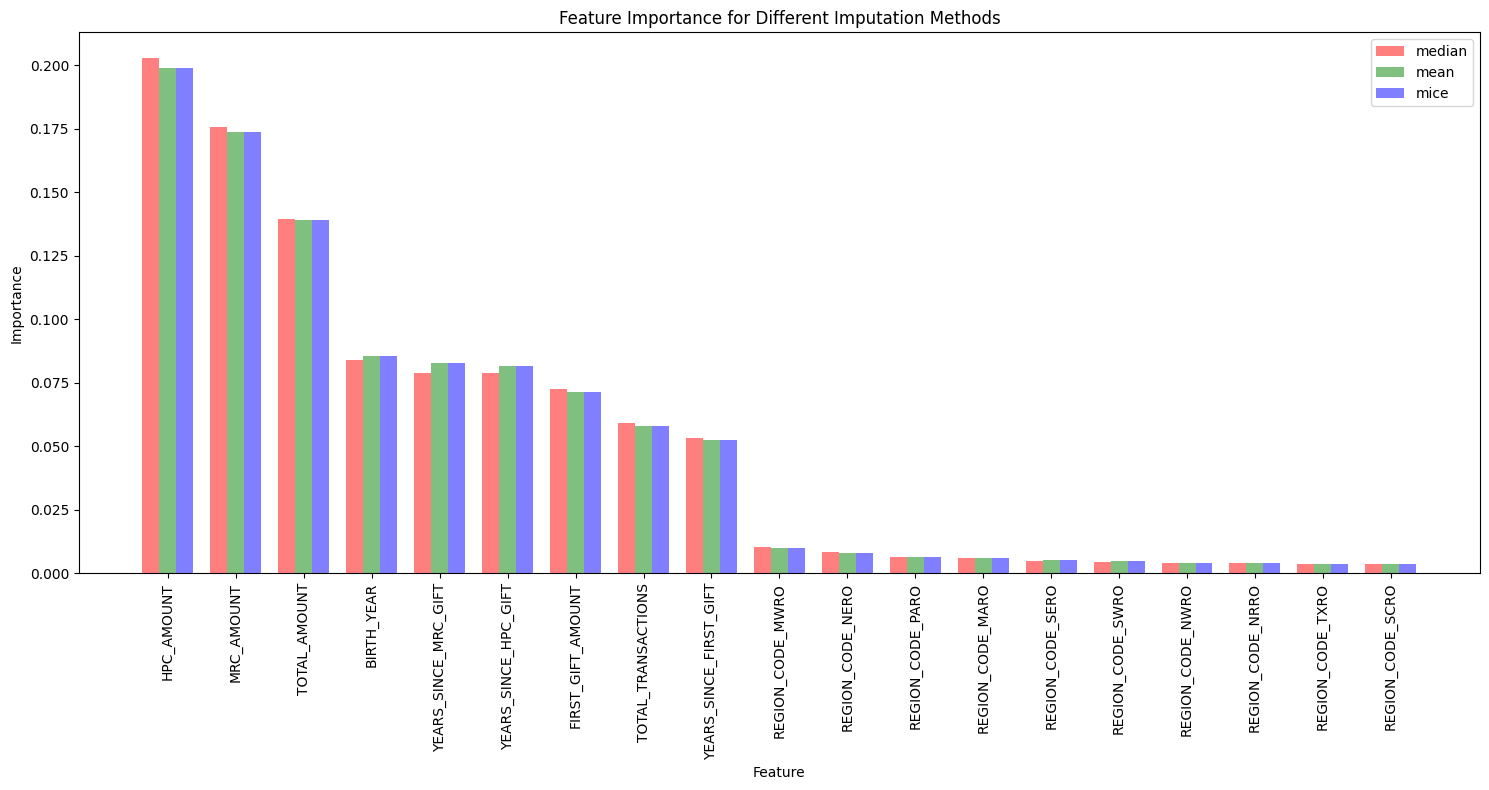

In [64]:
# Plot feature importances
plt.figure(figsize=(15, 8))
colors = {'median': 'red', 'mean': 'green', 'mice': 'blue'}
bar_width = 0.25
positions = np.arange(len(feature_importances['median']))

for i, result in enumerate(results):
    imputer_name = result['imputer']
    plt.bar(positions + i * bar_width, result['feature_importance']['Importance'], bar_width,
            alpha=0.5, label=imputer_name, color=colors[imputer_name])

plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Different Imputation Methods')
plt.xticks(positions + bar_width, feature_importances['median']['Feature'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


## Life Expectancy Prediction